In [44]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn
import string
import re

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Cleaning
import nltk
nltk.download("stopwords")
nltk.download('brown')
from nltk.corpus import stopwords
import contractions
from textblob import TextBlob
# Part of the Speech Tagging and Lemmatization
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.stem import WordNetLemmatizer
import torch

stop = set(stopwords.words('english'))

# Visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from wordcloud import WordCloud
import seaborn as sns
from PIL import Image

# Models
import transformers
from transformers import BertTokenizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
def cleaning(text):

    # Lower case
    text = text.lower()

    # Remove Contractions
    text = contractions.fix(text)

    # Remove special characters
    text = re.sub('\[.*?\]', '', text)

    # Remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # Remove html tags
    text = re.sub ('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)

    # Remove non ASCII characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    # Remove punctuation
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Remove words with numbers in them
    text = re.sub('\w*\d\w*', '', text)

    # Remove Slangs
    text = slang_clean(text)

    # Spellings correction
    #text = TextBlob(text).correct()

    # Remove stop words
    text = ' '.join(word for word in text.split(' ') if word not in stop)
    
    # Remove \n and \r
    text = re.sub(r'(\n)+', ' ', text)
    text = re.sub(r'(\r)+', '', text)

    # Remove starting and ending spaces
    text = re.sub(r'^\s+|\s+$', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    return text

def slang_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text

In [7]:
train['text_clean'] = train['comment_text'].apply(lambda x: cleaning(x))
test['text_clean'] = test['comment_text'].apply(lambda x: cleaning(x))
display(train.head(10))
display(test.head(10))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_clean
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0,explanation why edits made username hardcore m...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww matches background colour seemingly stuck...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0,more i cannot make real suggestions improvemen...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page
5,00025465d4725e87,"""\r\n\r\nCongratulations from me as well, use ...",0,0,0,0,0,0,congratulations well use tools well talk
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,cocksucker piss around work
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,vandalism matt shirvington article reverted pl...
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,sorry word nonsense offensive anyway intending...
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,alignment subject contrary dulithgow


,id,comment_text,text_clean
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule succesful ever hating sad mof...
1,0000247867823ef7,== From RfC == \r\n\r\n The title is fine as i...,rfc title fine going
2,00013b17ad220c46,""" \r\n\r\n == Sources == \r\n\r\n * Zawe Ashto...",sources zawe ashton lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...",look back source information updated correct f...
4,00017695ad8997eb,I don't anonymously edit articles at all.,anonymously edit articles
5,0001ea8717f6de06,Thank you for understanding. I think very high...,thank understanding think highly would revert ...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,please add nonsense wikipedia edits considered...
7,000247e83dcc1211,:Dear god this site is horrible.,dear god site horrible
8,00025358d4737918,""" \r\n Only a fool can believe in such numbers...",fool believe numbers correct number lies ponde...
9,00026d1092fe71cc,== Double Redirects == \r\n\r\n When fixing do...,double redirects fixing double redirects blank...


In [49]:
mask = np.array(Image.open('./images/wikipedia_mask.jpg'))

def generate_wordcloud(df, clm):
    text = []
    comments = train.loc[df[clm] == 1]['text_clean']

    for c in comments:
        text.append(c) 
    words = ' '.join(text)
    return WordCloud(stopwords=stop, background_color='white', mask=mask, height=1500, width=1500).generate(words)

In [50]:
train_toxic = generate_wordcloud(train, 'toxic')
train_sev_toxic = generate_wordcloud(train, 'severe_toxic')
train_obscene = generate_wordcloud(train, 'obscene')
train_threat = generate_wordcloud(train, 'threat')
train_insult = generate_wordcloud(train, 'insult')
train_id_hate = generate_wordcloud(train, 'identity_hate')
train_general = WordCloud(stopwords=stop, background_color='white', height=1500, width=4500).generate(" ".join(train['text_clean']))

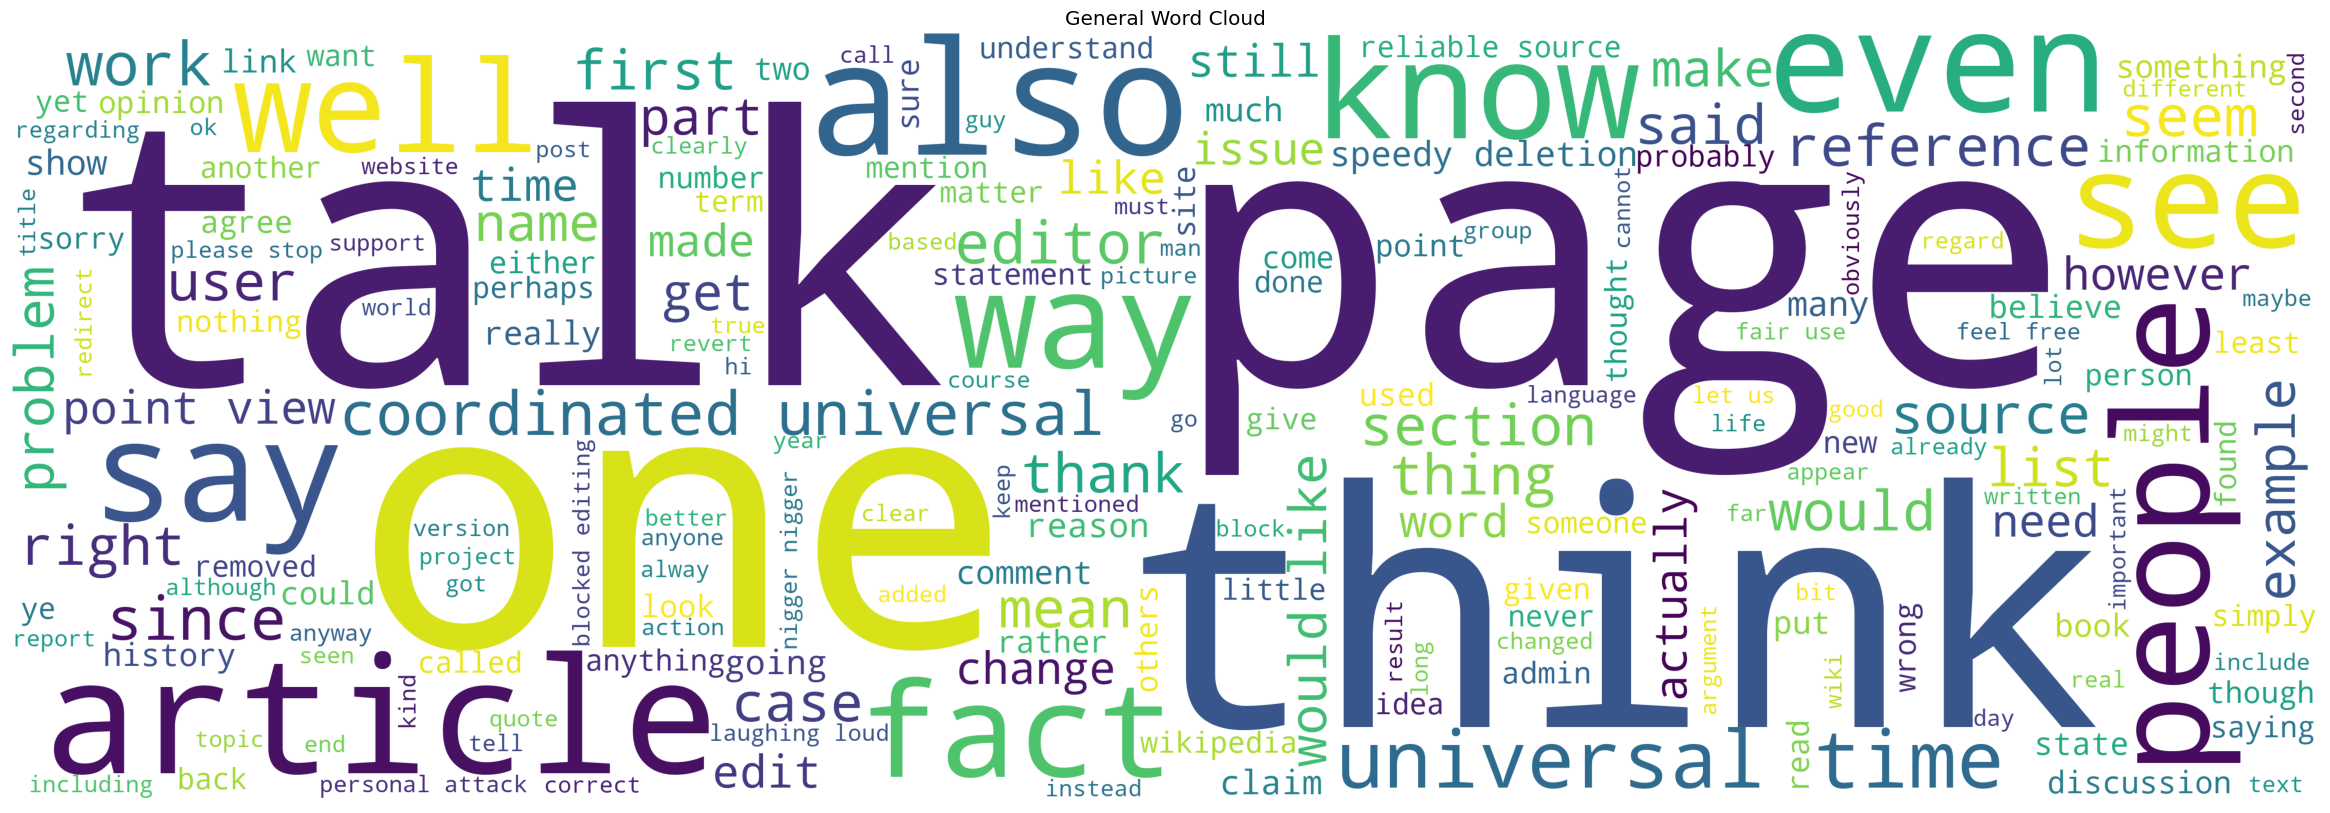

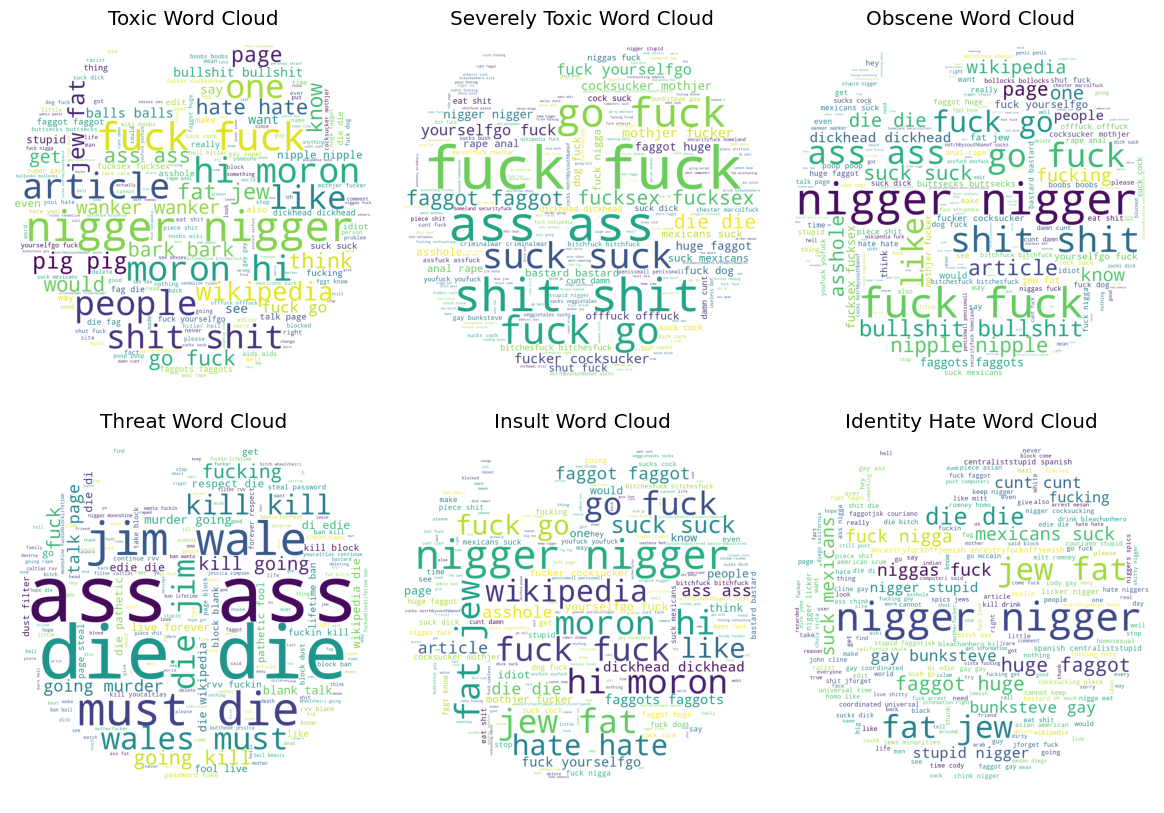

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(45, 10), gridspec_kw = {'wspace':0.01, 'hspace':0.1})
axes.imshow(train_general)
axes.axis('off')
axes.set_title('General Word Cloud')

plt.show()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), gridspec_kw = {'wspace':0.01, 'hspace':0.1})


axes[0][0].imshow(train_toxic)
axes[0][0].axis('off')
axes[0][0].set_title('Toxic Word Cloud')
axes[0][0].set_aspect('equal')

axes[0][1].imshow(train_sev_toxic)
axes[0][1].axis('off')
axes[0][1].set_title('Severely Toxic Word Cloud')
axes[0][1].set_aspect('equal')

axes[0][2].imshow(train_obscene)
axes[0][2].axis('off')
axes[0][2].set_title('Obscene Word Cloud')
axes[0][2].set_aspect('equal')

axes[1][0].imshow(train_threat)
axes[1][0].axis('off')
axes[1][0].set_title('Threat Word Cloud')
axes[1][0].set_aspect('equal')

axes[1][1].imshow(train_insult)
axes[1][1].axis('off')
axes[1][1].set_title('Insult Word Cloud')
axes[1][1].set_aspect('equal')

axes[1][2].imshow(train_id_hate)
axes[1][2].axis('off')
axes[1][2].set_title('Identity Hate Word Cloud')
axes[1][2].set_aspect('equal')


plt.show()

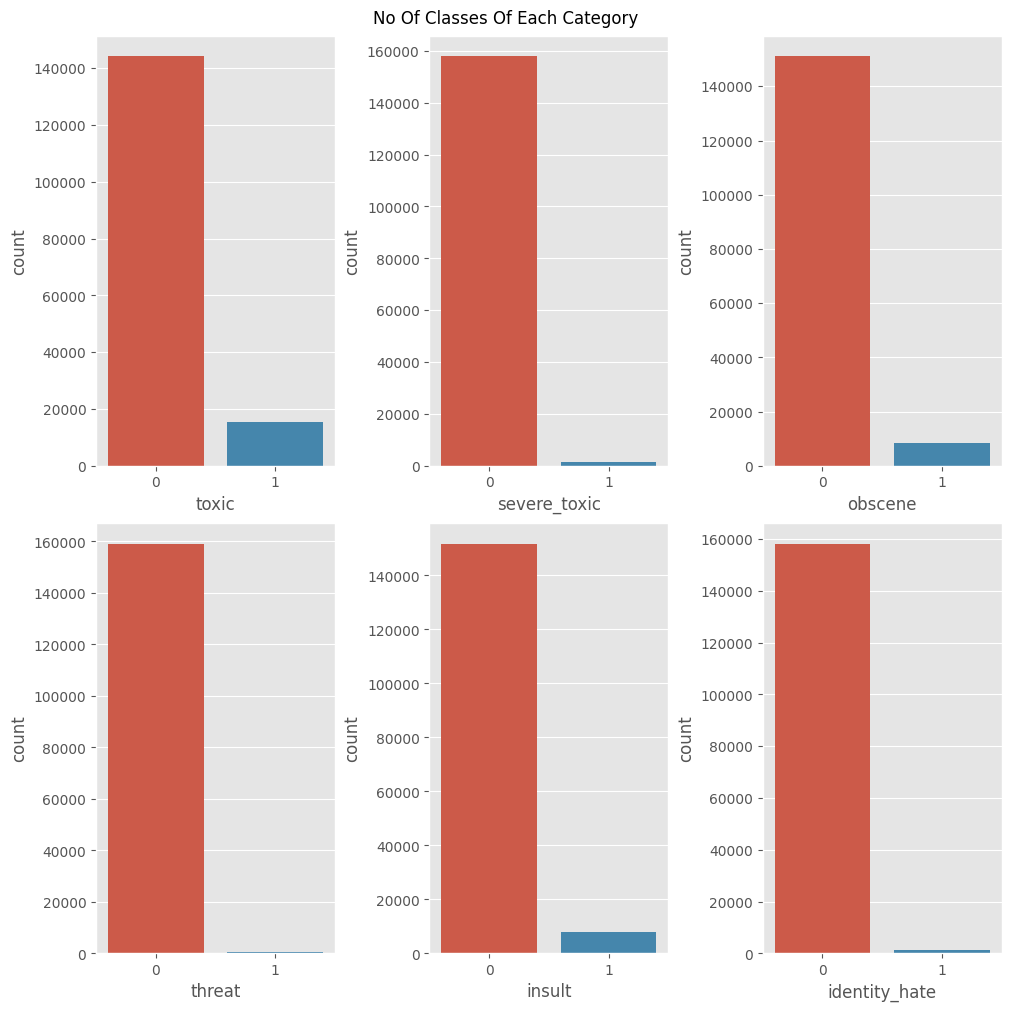

In [13]:
fig , axes = plt.subplots(2,3,figsize = (10,10), constrained_layout = True)
sns.countplot(ax=axes[0,0],x='toxic',data=train )
sns.countplot(ax=axes[0,1],x='severe_toxic',data=train)
sns.countplot(ax=axes[0,2],x='obscene',data=train)
sns.countplot(ax = axes[1,0],x='threat',data=train)
sns.countplot(ax=axes[1,1],x='insult',data=train)
sns.countplot(ax=axes[1,2],x='identity_hate',data=train)
plt.suptitle('No Of Classes Of Each Category')
plt.show()

In [ ]:
# Part of Speech Tagging
wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV
              }
    
train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type="pos_tag"):
    """
        Create pos_tag with wordnet format
    """
    
    pos_tagged_text = t2.tag(text)
    
    # map the pos tagging output with wordnet output 
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
   
    return pos_tagged_text

# Lemmatization
def lemmatize_word(text):
    
    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(word, tag) for word, tag in text]
    return lemma

In [ ]:
# Apply Pos Tagging
train['separated'] = train['text_clean'].apply(lambda x: [x for x in x.split()])
train['text_pos'] = train['separated'].apply(lambda x: pos_tag_wordnet(x)) 
test['separated'] = test['text_clean'].apply(lambda x: [x for x in x.split()])
test['text_pos'] = test['separated'].apply(lambda x: pos_tag_wordnet(x))
display(train['text_pos'].head(10))
display(test['text_pos'].head(10))

In [ ]:
# Apply Lemmatization
train['text_lem_wpos'] = train['text_pos'].apply(lambda x: lemmatize_word(x))
train['text_lem'] = [' '.join(map(str,l)) for l in train['text_lem_wpos']]
test['text_lem_wpos'] = test['text_pos'].apply(lambda x: lemmatize_word(x))
test['text_lem'] = [' '.join(map(str,l)) for l in test['text_lem_wpos']]
display(train['text_lem'].head(10))
display(test['text_lem'].head(10))

In [ ]:
train.to_csv('data/train_clean.csv', index=False)
test.to_csv('data/test_clean.csv', index=False)

In [ ]:
#Text Feature Extraction
def count_vectorize(data, max_features=75000):
    """
        Count Vectorize
    """
    count_vectorizer = CountVectorizer(ngram_range = (1,1), max_features=max_features)
    embedding = count_vectorizer.fit_transform(data).toarray()

    return embedding, count_vectorizer


In [ ]:
#train_corpus = train['text_lem'][:5].tolist()
#print("The test corpus: ", train_corpus, "\n")

train_emb_vect, count_vectorizer = count_vectorize(train['text_lem'].tolist())
#print(count_vectorizer.vocabulary_)

In [ ]:
 # TD-IDF
def TFIDF(data, max_features=1000):
    """
        TF-IDF
    """
    tfidf = TfidfVectorizer(ngram_range = (1,2), max_features=max_features)
    embedding = tfidf.fit_transform(data).toarray()

    return embedding, tfidf

In [ ]:
train_emb_tfidf, tfidf = TFIDF(train['text_lem'].tolist())

In [ ]:
# ----------- FINE PREPROCESSING -------------#

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
'''
    Add special tokens to the start and end of each sentence.
    Pad & truncate all sentences to a single constant length.
    Explicitly differentiate real tokens from padding tokens with the “attention mask”.

'''
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text = sent,
            add_special_tokens = True,
            max_length = 300,
            pad_to_max_length = True,
            truncation = True,
            return_attention_mask = True
        )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    
    # Convert the lists into tensors.
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
from sklearn.model_selection import train_test_split
X = train['text_lem'].tolist()
Y = train['toxic'].tolist()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=2021)

In [ ]:
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.LSTM = nn.LSTM(D_in,D_in,bidirectional=True)
        # self.clf = nn.Linear(D_in*2,2)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            # nn.LSTM(D_in,D_in)
            nn.Linear(D_in, H),
            nn.GELU(), 
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=1e-4,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time
from tqdm import tqdm

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    best_accuracy = 0
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()
        step = 0
        # For each batch of training data...
        for batch in tqdm(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                #print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
        step += 1
        output_folder = "bert_classifier"
        filename="./trained_models/"+str(output_folder)

        # create folder if it does not exist

        if not os.path.exists(filename):
            os.makedirs(filename)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            filename="./trained_models/"+str(output_folder)+"/best.pt"
            torch.save(model.state_dict(), filename)

        filename="./trained_models/"+str(output_folder)+"/last.pt"
        torch.save(model.state_dict(), filename)
    
    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)